Machine Learning for Credit Scoring

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Read the data :

# We take the url to download our Dataset : 

Data = pd.read_csv("Loan_data.csv", low_memory = False)
Data.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# We need to check how is our dataset :
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [4]:
# Checking for missing values :
Data.isnull().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
all_util            466285
total_rev_hi_lim     70276
inq_fi              466285
total_cu_tl         466285
inq_last_12m        466285
Length: 74, dtype: int64

In [5]:
# Dropping the missing values :

# We tried to erase rows with missing values but it erases every columns.
# Maybe we could decide to remove COLUMNS with missing values instead of rows.
# It is 'less professional' but it is also an easy way to remove features as we have too many of them.

# We decide to remove columns with more than 10% missing values then remove rows which still have missing values.
# It lets us to keep more features.

Data.dropna(axis = 1, thresh = Data.shape[0]*0.9, inplace = True) # axis=1 is to remove comlumns instead of rows
Data.dropna(axis = 0, inplace = True) # axis0 is to remove rows which contain missing values
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437710 entries, 1 to 466283
Data columns (total 49 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          437710 non-null  int64  
 1   member_id                   437710 non-null  int64  
 2   loan_amnt                   437710 non-null  int64  
 3   funded_amnt                 437710 non-null  int64  
 4   funded_amnt_inv             437710 non-null  float64
 5   term                        437710 non-null  object 
 6   int_rate                    437710 non-null  float64
 7   installment                 437710 non-null  float64
 8   grade                       437710 non-null  object 
 9   sub_grade                   437710 non-null  object 
 10  emp_title                   437710 non-null  object 
 11  emp_length                  437710 non-null  object 
 12  home_ownership              437710 non-null  object 
 13  annual_inc    

In [6]:
# Checking for missing values again :
Data.isnull().sum()
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437710 entries, 1 to 466283
Data columns (total 49 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          437710 non-null  int64  
 1   member_id                   437710 non-null  int64  
 2   loan_amnt                   437710 non-null  int64  
 3   funded_amnt                 437710 non-null  int64  
 4   funded_amnt_inv             437710 non-null  float64
 5   term                        437710 non-null  object 
 6   int_rate                    437710 non-null  float64
 7   installment                 437710 non-null  float64
 8   grade                       437710 non-null  object 
 9   sub_grade                   437710 non-null  object 
 10  emp_title                   437710 non-null  object 
 11  emp_length                  437710 non-null  object 
 12  home_ownership              437710 non-null  object 
 13  annual_inc    

In [7]:
# We compute the base rate to check if our dataset is balanced :
Data.grade.value_counts()/Data.shape[0]

# We observe a huge difference between the grades so we will have to change that.

B    0.293774
C    0.268865
D    0.164465
A    0.160718
E    0.076649
F    0.028402
G    0.007126
Name: grade, dtype: float64

In [8]:
Data.grade.value_counts()

# We see that the smaller group has 3119 values. The idea is to delete enough observations in the other groups to have 
# a balanced dataset.

B    128588
C    117685
D     71988
A     70348
E     33550
F     12432
G      3119
Name: grade, dtype: int64

In [9]:
# We remove columns which are not useful for our study :

Data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'loan_status', 'pymnt_plan',
                          'zip_code', 'initial_list_status', 'application_type', 'url', 'policy_code'], inplace = True)

In [10]:
# We change the way dates are given in the dataset :

Data['term'] = Data['term'].str.replace(' months','')
Data['term'] = Data['term'].astype(int)

In [11]:
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])

In [12]:
# We change the type and the format of emp_length :

emp_length_converter(Data,'emp_length')
Data['emp_length']

1          0
3         10
4          1
5          3
6          8
          ..
466279     4
466280     4
466281    10
466282     7
466283     3
Name: emp_length, Length: 437710, dtype: int64

In [13]:
def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2022-04-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

In [14]:
date_columns(Data, 'earliest_cr_line')
date_columns(Data, 'issue_d')
date_columns(Data, 'last_pymnt_d')
date_columns(Data, 'last_credit_pull_d')

In [15]:
# Verification of the modified dates in the dataset :

Data[['mths_since_earliest_cr_line', 'mths_since_issue_d', 'mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d']]

,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
1,276.0,124.0,108.0,103.0
3,314.0,124.0,87.0,87.0
4,315.0,124.0,75.0,75.0
5,209.0,124.0,87.0,79.0
6,201.0,124.0,75.0,75.0
...,...,...,...,...
466279,272.0,99.0,75.0,75.0
466280,228.0,99.0,75.0,75.0
466281,298.0,99.0,88.0,75.0
466282,244.0,99.0,75.0,76.0


In [16]:
# The smaller group has 3119 observations and we want to remove enough rows in other groups to have the same number in each
# group

# We define NbA, NbB, NbC, NbD, NbE, NbF and NbG the numbers of rows in each group for the moment :

NbA = 70348
NbB = 128588
NbC = 117685
NbD = 71988
NbE = 33550
NbF = 12432
NbG = 3119

ListNbRows = [NbA, NbB, NbC, NbD, NbE, NbF]

# We define ListNbRowsToDelete the list of the numbers of rows we need to delete for each group :

ListNbRowsToDelete = []
for i in ListNbRows:
    ListNbRowsToDelete.append(i - NbG)

In [17]:
# We divide our dataset in different groups, one for each grade. Then we could delete the number of rows we want for each group.

groups = Data.groupby(Data.grade)

Data_A = groups.get_group('A')
Data_B = groups.get_group('B')
Data_C = groups.get_group('C')
Data_D = groups.get_group('D')
Data_E = groups.get_group('E')
Data_F = groups.get_group('F')
Data_G = groups.get_group('G')

# To make it easier for after we put them in a list :

listGroup = [Data_A, Data_B, Data_C, Data_D, Data_E, Data_F]

In [18]:
# We randomly remove the overpart of each group :

In [19]:
# Firt we try to remove rows one by one, it is the best way to be random :

#for i in range(6):
#    while  ListNbRowsToDelete[i] > 0:
#        n = random.randrange(0, len(listGroup[i].index))
#        listGroup[i] = listGroup[i].drop([listGroup[i].index[n]])
#        ListNbRowsToDelete[i] = ListNbRowsToDelete[i] - 1
        
# Unfortunately this code is very long to run (approximately 3h)

In [20]:
# We try to remove rows ten by ten to obtain a quicker result and it works, it is around 15 min to run!
# It is almost the same code as before :

for i in range(6):
    while  ListNbRowsToDelete[i] > 0:
        n = random.randrange(0, len(listGroup[i].index)-9)
        listGroup[i] = listGroup[i].drop([listGroup[i].index[n], listGroup[i].index[n+1], listGroup[i].index[n+2],
                                         listGroup[i].index[n+3], listGroup[i].index[n+4], listGroup[i].index[n+5],
                                         listGroup[i].index[n+6], listGroup[i].index[n+7], listGroup[i].index[n+8],
                                         listGroup[i].index[n+9]])
        ListNbRowsToDelete[i] = ListNbRowsToDelete[i] - 10
        
# It took 14 min to run
# Attention it does not change Data_A, Data_B etc. It modifies only the list listGroup!

In [21]:
# Now we can concatenate the new DataFrame : 

DataNew = pd.concat(listGroup + [Data_G])

DataNew.shape

(21810, 38)

In [22]:
# As we delete 10 by 10, we do not delete the exact number of rows for each grade
# It is not important but it is to explain why each grade do not have the same rate
print(ListNbRowsToDelete)

[-1, -1, -4, -1, -9, -7]


In [24]:
DataNew.grade.value_counts()/DataNew.shape[0]

G    0.143008
A    0.142962
B    0.142962
D    0.142962
C    0.142824
F    0.142687
E    0.142595
Name: grade, dtype: float64

In [25]:
# In order to work quicker we save the clean dataframe to csv
# We don't have to run the code to clean before each session, we just need to import the following dataframe :
# DataNew.to_csv("cleanData.csv")

In [38]:
# To continue we just open the dataset we saved before :

DataNew = pd.read_csv("cleanData.csv", low_memory=False)
DataNew.head()

,Unnamed: 0,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
0,1158,12000,12000,12000.0,36,7.51,373.33,A,7,RENT,...,0.0,0.0,0.0,390.85,0.0,0.0,283.0,124.0,88.0,88.0
1,1161,25850,25850,25850.0,36,7.90,808.86,A,10,MORTGAGE,...,0.0,0.0,0.0,815.94,0.0,0.0,280.0,124.0,88.0,88.0
2,1165,8000,8000,8000.0,36,7.51,248.89,A,0,RENT,...,0.0,0.0,0.0,264.26,0.0,0.0,210.0,124.0,88.0,78.0
3,1169,4000,4000,4000.0,36,7.90,125.17,A,5,RENT,...,0.0,0.0,0.0,1566.18,0.0,0.0,266.0,124.0,100.0,77.0
4,1171,14000,14000,14000.0,60,8.90,289.94,A,1,RENT,...,0.0,0.0,0.0,289.94,0.0,0.0,273.0,124.0,75.0,75.0


In [39]:
# When we open again the cleaned dataset, we have a new column "Unnamed" with the old indexes.
# We delete it :

DataNew = pd.read_csv("cleanData.csv", low_memory = False)
DataNew.drop(columns = ['Unnamed: 0'], inplace = True)

In [40]:
# We divide our dataset in two parts, one for our target variable and the other one for the other ones :

from sklearn.model_selection import train_test_split
X = DataNew.drop('grade', axis = 1)
y = DataNew['grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [41]:
# We divide our training data into categorical and numerical subsets :

X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [42]:
# X_train_num
DataNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21810 entries, 0 to 21809
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   loan_amnt                      21810 non-null  int64  
 1   funded_amnt                    21810 non-null  int64  
 2   funded_amnt_inv                21810 non-null  float64
 3   term                           21810 non-null  int64  
 4   int_rate                       21810 non-null  float64
 5   installment                    21810 non-null  float64
 6   grade                          21810 non-null  object 
 7   emp_length                     21810 non-null  int64  
 8   home_ownership                 21810 non-null  object 
 9   annual_inc                     21810 non-null  float64
 10  verification_status            21810 non-null  object 
 11  purpose                        21810 non-null  object 
 12  title                          21810 non-null 

In [43]:
# Define an empty dictionary to store chi-squared test results :
chi2_check = {}

In [44]:
from scipy.stats import chi2_contingency
# We loop over each column in the training set to compute chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

In [45]:
# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,home_ownership,0.0000
1,verification_status,0.0000
2,purpose,0.0000
3,title,0.0000
4,addr_state,0.0827


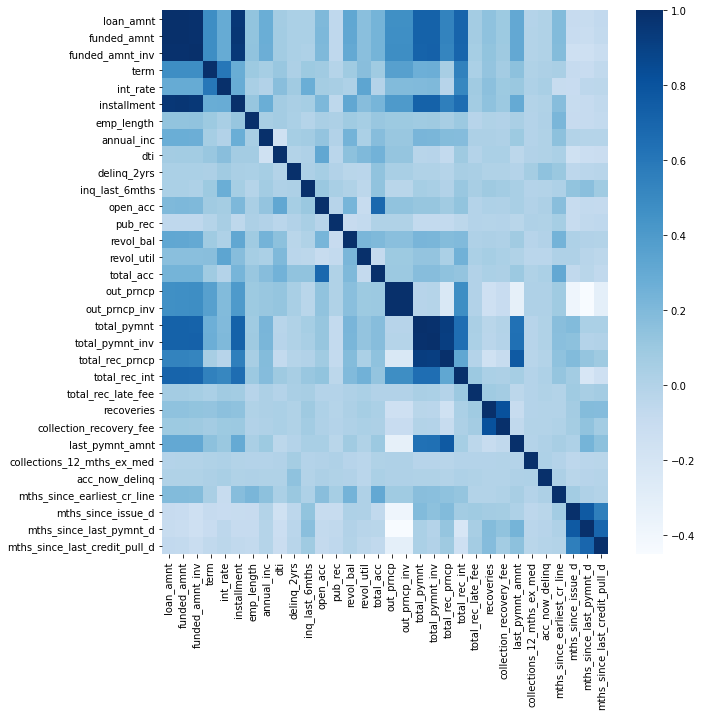

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
# calculate pair-wise correlations between them
corrmat = X_train_num.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat, cmap="Blues")

In [47]:
# We delete all the features whose correlations are greater than 0.7 in absolute value : 

corrmat[abs(corrmat) > 0.7]
DataNew.drop(columns = ['funded_amnt', 
                        'funded_amnt_inv', 
                        'installment', 
                        'total_pymnt_inv', 
                        'collection_recovery_fee', 
                        'mths_since_last_pymnt_d', 
                        'out_prncp_inv', 
                        'total_rec_prncp'], 
             inplace = True)

In [48]:
# We factorize categorical features :

for j in range(len(X_train.columns)):
    if(X_train.dtypes[j] == 'object'):
        X_train[X_train.columns[j]] = pd.factorize(X_train[X_train.columns[j]])[0].tolist()
        X_test[X_test.columns[j]] = pd.factorize(X_test[X_test.columns[j]])[0].tolist()


<ipython-input-48-76d8ec587ec8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns[j]] = pd.factorize(X_train[X_train.columns[j]])[0].tolist()
<ipython-input-48-76d8ec587ec8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[X_test.columns[j]] = pd.factorize(X_test[X_test.columns[j]])[0].tolist()


In [49]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [50]:
# We normalize numerical features :

X_train[X_train_num.columns] = mean_norm(X_train[X_train_num.columns])
X_test[X_train_num.columns] = mean_norm(X_test[X_train_num.columns])

C:\Users\albon\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [51]:
# Now we have a cleaned dataset and we can apply several classification models.
# NB : we have to say 'classification' as we want to predict CATEGORICAL values (label).
# 'Regression' is for numerical values (quantity).
# For each model we will compute the accuracy to find the best one.
# To do that we create a list to store the accuracies
ListAcc = []

Logistic Regression (It is a classification but this tool is called Logistic Regression)

In [52]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

classifier1 = LogisticRegression()
classifier1.fit(X_train, y_train)

C:\Users\albon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [53]:
RegPred1 = classifier1.predict(X_test)

In [54]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing

In [55]:
# Results for Logistic Regression :

cf_matrix1 = confusion_matrix(y_test, RegPred1, labels = ["A", "B", "C", "D", "E", "F", "G"]) # Confusion Matrix Calculus
ClassReport1 = classification_report(y_test, RegPred1)
acc1 = accuracy_score(y_test, RegPred1)

ListAcc.append(acc1)

print(cf_matrix1)
print(ClassReport1)
print(acc1)

[[561  25  10   0  23   0   4]
 [383 116  43   5  47   0  30]
 [189 133  75  25 124   0  77]
 [ 78 121  58  81 139   1 146]
 [ 32  42  64  79 142  17 246]
 [ 18  22  29  56 131  39 327]
 [ 13   6   6  45 114  44 396]]
              precision    recall  f1-score   support

           A       0.44      0.90      0.59       623
           B       0.25      0.19      0.21       624
           C       0.26      0.12      0.17       623
           D       0.28      0.13      0.18       624
           E       0.20      0.23      0.21       622
           F       0.39      0.06      0.11       622
           G       0.32      0.63      0.43       624

    accuracy                           0.32      4362
   macro avg       0.31      0.32      0.27      4362
weighted avg       0.31      0.32      0.27      4362

0.32324621733149933


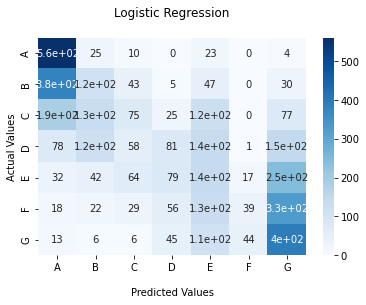

In [56]:
# To plot the confusion matrix :

ax = sns.heatmap(cf_matrix1, annot = True, cmap = "Blues")

ax.set_title('Logistic Regression\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])
ax.yaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])

plt.show()

KNN Classification

In [58]:
# To do KNN Classification we need to find the best parameters
# We tun hyperparameters with GridSearch (for n_neighbors, p and weights)
# It is a bit long to run (approx 3 min)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define parameters to test
grid = {'n_neighbors':np.arange(1,7),
        'p':np.arange(1,3),
        'weights':['uniform','distance']
       }

# Define and fit model
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, grid, cv=10)

knn_cv.fit(X_train, y_train)

nb = knn_cv.best_params_['n_neighbors']
p = knn_cv.best_params_['p']
w = knn_cv.best_params_['weights']

# Print results
print("Hyperparameters:", knn_cv.best_params_)
print("Train Score:", round(knn_cv.best_score_, 4))

Hyperparameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Train Score: 0.352


In [59]:
# We do the KNN Classification with the best parameters :

classifier2 = KNeighborsClassifier(n_neighbors=nb, p = p, weights = w)
classifier2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

In [60]:
RegPred2 = classifier2.predict(X_test)

In [61]:
# Results for KNN Classification :

cf_matrix2 = confusion_matrix(y_test, RegPred2, labels = ["A", "B", "C", "D", "E", "F", "G"]) # Confusion Matrix Calculus
ClassReport2 = classification_report(y_test, RegPred2)
acc2 = accuracy_score(y_test, RegPred2)

ListAcc.append(acc2)

print(cf_matrix2)
print(ClassReport2)
print(acc2)

[[379 133  49  29  12  18   3]
 [154 239 102  58  33  32   6]
 [ 70 149 191 114  54  34  11]
 [ 47 100 125 158  99  58  37]
 [ 29  53  97 103 148 116  76]
 [ 20  31  53  59 102 205 152]
 [ 19  27  37  52  95 165 229]]
              precision    recall  f1-score   support

           A       0.53      0.61      0.57       623
           B       0.33      0.38      0.35       624
           C       0.29      0.31      0.30       623
           D       0.28      0.25      0.26       624
           E       0.27      0.24      0.25       622
           F       0.33      0.33      0.33       622
           G       0.45      0.37      0.40       624

    accuracy                           0.36      4362
   macro avg       0.35      0.36      0.35      4362
weighted avg       0.35      0.36      0.35      4362

0.3551123337918386


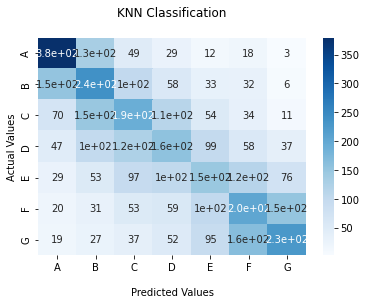

In [62]:
# To plot the confusion matrix :

ax = sns.heatmap(cf_matrix2, annot = True, cmap = "Blues")

ax.set_title('KNN Classification\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])
ax.yaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])

plt.show()

Decision Tree Classification

In [63]:
# To do Decision Tree Classification we also need to find the best parameter
# We tun hyperparameters with GridSearch (for depth)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter to test
grid = {'max_depth':np.arange(1,10)}

# Define and fit model

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, grid, cv=5)

tree_cv.fit(X_train, y_train)

d = tree_cv.best_params_

# Print results
print("Hyperparameters:", tree_cv.best_params_)
print("Train Score:", round(tree_cv.best_score_, 4))

Hyperparameters: {'max_depth': 9}
Train Score: 0.9864


In [64]:
# We do the Decision Tree Classification with the best depth :

classifier3 = DecisionTreeClassifier(max_depth=9, random_state=72) #best parameter we found
classifier3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, random_state=72)

In [65]:
RegPred3 = classifier3.predict(X_test)

In [66]:
# Results for Decision Tree Classification :

cf_matrix3 = confusion_matrix(y_test, RegPred3, labels = ["A", "B", "C", "D", "E", "F", "G"]) # Confusion Matrix Calculus
ClassReport3 = classification_report(y_test, RegPred3)
acc3 = accuracy_score(y_test, RegPred3)

ListAcc.append(acc3)

print(cf_matrix3)
print(ClassReport3)
print(acc3)

[[611   9   0   1   2   0   0]
 [  0 613  11   0   0   0   0]
 [  1  20 600   2   0   0   0]
 [  0   0   6 603  15   0   0]
 [  0   0   0  10 610   2   0]
 [  0   0   0   0  10 607   5]
 [  0   0   0   0   1   5 618]]
              precision    recall  f1-score   support

           A       1.00      0.98      0.99       623
           B       0.95      0.98      0.97       624
           C       0.97      0.96      0.97       623
           D       0.98      0.97      0.97       624
           E       0.96      0.98      0.97       622
           F       0.99      0.98      0.98       622
           G       0.99      0.99      0.99       624

    accuracy                           0.98      4362
   macro avg       0.98      0.98      0.98      4362
weighted avg       0.98      0.98      0.98      4362

0.9770747363594682


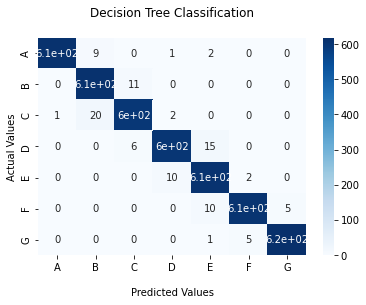

In [67]:
# To plot the confusion matrix :

ax = sns.heatmap(cf_matrix3, annot = True, cmap = "Blues")

ax.set_title('Decision Tree Classification\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])
ax.yaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])

plt.show()

Random Forest Classification

In [68]:
# We do the Random Forest Classification :

from sklearn.ensemble import RandomForestClassifier

classifier4 = RandomForestClassifier(n_estimators=100)
classifier4.fit(X_train, y_train)

RandomForestClassifier()

In [69]:
RegPred4 = classifier4.predict(X_test)

In [70]:
# Results for Random Forest Classification :

cf_matrix4 = confusion_matrix(y_test, RegPred4, labels = ["A", "B", "C", "D", "E", "F", "G"]) # Confusion Matrix Calculus
ClassReport4 = classification_report(y_test, RegPred4)
acc4 = accuracy_score(y_test, RegPred4)

ListAcc.append(acc4)

print(cf_matrix4)
print(ClassReport4)
print(acc4)

[[616   7   0   0   0   0   0]
 [  5 571  48   0   0   0   0]
 [  1  34 546  42   0   0   0]
 [  0   2  24 551  47   0   0]
 [  0   0   1  42 552  25   2]
 [  0   0   0   4  34 566  18]
 [  0   0   0   3   8  19 594]]
              precision    recall  f1-score   support

           A       0.99      0.99      0.99       623
           B       0.93      0.92      0.92       624
           C       0.88      0.88      0.88       623
           D       0.86      0.88      0.87       624
           E       0.86      0.89      0.87       622
           F       0.93      0.91      0.92       622
           G       0.97      0.95      0.96       624

    accuracy                           0.92      4362
   macro avg       0.92      0.92      0.92      4362
weighted avg       0.92      0.92      0.92      4362

0.9160935350756534


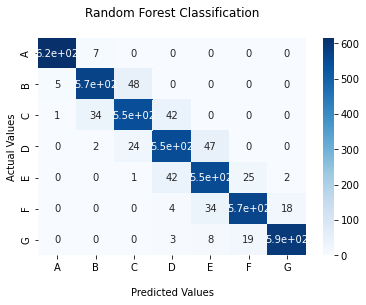

In [71]:
# To plot the confusion matrix :

ax = sns.heatmap(cf_matrix4, annot = True, cmap = "Blues")

ax.set_title('Random Forest Classification\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])
ax.yaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])

plt.show()

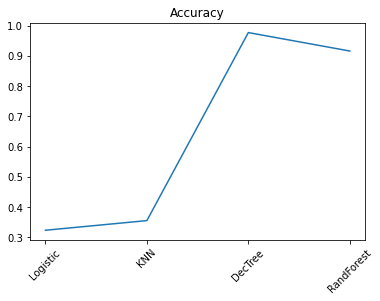

In [72]:
# Let's compare our previous results

# We plot the list of accuracies and we put a name for each point :
labels = ['Logistic', 'KNN', 'DecTree', 'RandForest']

x = [i for i in range(1,5)]
plt.title('Accuracy')
plt.plot(x, ListAcc)
plt.xticks(x, labels, rotation = 45)

plt.show()

We can observe that Decision Tree and Random Forest are way more efficient. Logistic and KNN are almost equal.